In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import urllib.request as request

In [6]:
# Download Data
data_url="https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [20]:
class Config:
    def __init__(self):
        self.ROOT_DATA_DIR="Image_Data_Dir"
        self.EPOCH=100
        self.BATCH_SIZE=32
        self.LEARNING_RATE=0.001
        self.IMAGE_SIZE=(224,224)
        self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
        print(f"This notebook is using the device: {self.DEVICE}")
        self.SEED=2022
        
    def create_dir(self, dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print(f"{dir_path} directory is created")
config=Config()

This notebook is using the device: cpu


In [4]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)

Image_Data_Dir directory is created


In [5]:
data_zip_file="data.zip"

In [7]:
data_file_path=os.path.join(config.ROOT_DATA_DIR, data_zip_file)
request.urlretrieve(data_url, data_file_path)

('Image_Data_Dir\\data.zip', <http.client.HTTPMessage at 0x29081c59700>)

In [10]:
from zipfile import ZipFile
def unzip_file(source: str, dest: str) -> None:
    print(f"extraction started.....")
    
    with ZipFile(source, "r") as zip_f:
        zip_f.extractall(dest)
    print(f"extracted {source} to {dest}")

In [11]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

extraction started.....
extracted Image_Data_Dir\data.zip to Image_Data_Dir


In [16]:
# Create Data Loader
from pathlib import Path

In [17]:
train_path=Path("Image_Data_Dir/hymenoptera_data/train")
test_path=Path("Image_Data_Dir/hymenoptera_data/val")

In [18]:
mean=torch.tensor([0.5,0.5,0.5])
std=torch.tensor([0.5,0.5,0.5])


In [23]:
train_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
    
])
test_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
    
])

In [25]:
train_data=datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data=datasets.ImageFolder(root=test_path, transform=test_transforms)

In [26]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [27]:
label_map=train_data.class_to_idx

In [28]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: Image_Data_Dir\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [29]:
test_data

Dataset ImageFolder
    Number of datapoints: 153
    Root location: Image_Data_Dir\hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [30]:
train_loader=DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
train_loader=DataLoader(train_data,shuffle=False, batch_size=config.BATCH_SIZE)

In [31]:
data=next(iter(train_loader))

In [32]:
len(data)

2

In [33]:
images, labels=data


In [35]:
images.shape,  labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [36]:
# Visualize the imahes
img=images[0]
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


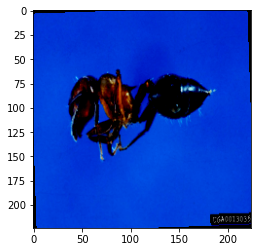

In [37]:
plt.imshow(img.permute(1,2,0))

In [ ]:
def count_params(model):
    model_params={"Modules":list(),"Parameters":list()}
    total={"trainable":0, "non_trainable":0}
    for name, parameters in model.named_parameters():
        param=parameters.numel()# Checking neumerical value
        if not parameters.requires_grad:
            total["non_trainable"] +=param
            continue
        
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] +=param
    df=pd.DataFrame(model_params)
    df=df.style.set_caption(f"Total trainable parameters: {total}")
    return df
    